In [11]:
import math
import re
import sys
import matplotlib.pyplot as plt 
import os
import numpy as np

In [12]:
train_data_directory = "train/"

### Word Count

In [13]:
ham_dictionary = {}    # stores words in ham files and their frequencies
spam_dictionary = {}    # stores words in spam files and their frequencies
vocabulary = set()    # stores unique words present in all files (spam and ham)

def word_count_directory(train_data_directory):
    
    # list of file paths for files in train_data_directory
    file_list = [os.path.join(train_data_directory,f) for f in os.listdir(train_data_directory)]
    
    # intialize no of spam and ham files
    no_of_spam_files = 0
    no_of_ham_files = 0
    
    for file_path in file_list:
        with open(file_path,encoding='latin-1') as infile:
            # to store type of file 'spam' or 'ham'
            file_type = ''
            if 'spam' in file_path:
                file_type = 'spam'
                no_of_spam_files += 1
            elif 'ham' in file_path:
                file_type = 'ham'
                no_of_ham_files += 1
                
            # Loop through each line of the file 
            for line in infile:
                 
                line = line.strip()    # Remove the leading spaces and newline character
                lower_line = str.lower(line)    # Convert characters in line to lowercase to avoid case mismatch
                valid_words = re.split('[^a-zA-Z]',lower_line) # filter words following the given regex
                valid_words = list(filter(None, valid_words))   # filter words with length greater than 0
                
                # Iterate over each word in line 
                for word in valid_words:
                    if file_type == 'ham':
                        # Check if the word is already in dictionary
                        if word in ham_dictionary:
                            ham_dictionary[word] += 1
                        else:
                            ham_dictionary[word] = 1     # add word to dictionary with count 1
                            vocabulary.add(word)     # add word to vocabulary set

                            # if this word is not present in spam_dictionary, add it with count 0
                            if word not in spam_dictionary:
                                spam_dictionary[word] = 0

                    elif file_type == 'spam':
                        # Check if the word is already in dictionary
                        if word in spam_dictionary:
                            spam_dictionary[word] += 1
                        else:
                            spam_dictionary[word] = 1    # add word to dictionary with count 1
                            vocabulary.add(word)    # add word to vocabulary set

                            # if this word is not present in ham_dictionary, add it with count 0
                            if word not in ham_dictionary:
                                ham_dictionary[word] = 0
    return no_of_spam_files,no_of_ham_files

### Prior Probabilities

In [14]:
no_of_spam_files, no_of_ham_files = word_count_directory(train_data_directory)
total_no_of_files = no_of_spam_files + no_of_ham_files
prior_prob_of_spam = no_of_spam_files / total_no_of_files
prior_prob_of_ham = no_of_ham_files / total_no_of_files

### Train model

In [15]:
def create_model(vocabulary,ham_dictionary,spam_dictionary):
    
    vocabulary = sorted(vocabulary)    # sorting the vocabulary to maintain order in model.txt
    f = open("model.txt","w+")    # creating file that would store the model
    N = len(vocabulary)    # getting size of vocabulary
    delta = 0.5    # smoothing value
    
    smoothed_N = (delta * N)
    # calculating smoothed denominator for calculating condinational probability of ham words
    ham_denominator = sum(ham_dictionary.values()) + smoothed_N
    
    # calculating smoothed denominator for calculating condinational probability of spam words
    spam_denominator = sum(spam_dictionary.values()) + smoothed_N
    
    for i,word in enumerate(vocabulary):
        
        freq_in_ham = ham_dictionary[word]    # frequency of word in ham dictionary
        c_p_in_ham = (freq_in_ham + delta) / ham_denominator    # conditional probabiltiy of word in ham
        freq_in_spam = spam_dictionary[word]    # frequency of word in spam dictionary
        c_p_in_spam = (freq_in_spam + delta) / spam_denominator    # conditional probabiltiy of word in spam
        
        ham_dictionary[word] = c_p_in_ham
        spam_dictionary[word] = c_p_in_spam
        
        # writing all data to model.txt
        f.write(str(i+1)+'  '+word+'  '+str(freq_in_ham)+'  '+str( "{:.8f}".format(float( c_p_in_ham )) )+'  '+str(freq_in_spam)+'  '+str( "{:.8f}".format(float( c_p_in_spam )) )+'\n')
    
    f.close()    # closing the file
    
create_model(vocabulary,ham_dictionary,spam_dictionary)

### Evaluate the model

In [16]:
test_data_directory = "test/"

# applying log10 on prior probabilities
log_of_ham = math.log10(prior_prob_of_ham)
log_of_spam = math.log10(prior_prob_of_spam)

# initialising variables needed for confusion matrix
true_positive = 0   # correct Ham -> result Ham
true_negative = 0    # correct Spam -> result Spam
false_positive = 0    # correct Spam -> result Ham
false_negative = 0    # correct Ham -> result Spam

file_list = [os.path.join(test_data_directory,f) for f in os.listdir(test_data_directory)]    # file paths of test files
temp_counter = 0    # counter to store the test file count

f = open("result.txt", "w+")   # 'w+' for reading and writing
f.truncate(0)

for file_path in file_list:
    
    with open(file_path,encoding = 'latin-1') as infile:

        file_name = file_path.rsplit('/',1)[1]    # file name to store in result.txt
        temp_counter = temp_counter + 1
        score_log_ham = log_of_ham     # score for ham
        score_log_spam = log_of_spam    # score for spam

        if("test-ham" in file_path):
            correct_classification = "ham"
        else:
            correct_classification = "spam"

        vocab_test = []    #  stores words in test file
        for line in infile:

            line = line.strip()    # Remove the leading spaces and newline character
            lower_line = str.lower(line)    # Convert characters in line to lowercase to avoid case mismatch
            valid_words = re.split('[^a-zA-Z]',lower_line) # filter words following the given regex
            valid_words = list(filter(None, valid_words))   # filter words with length greater than 0
            vocab_test = vocab_test + valid_words    # appending valid_words to vocab_test


        for word in vocab_test:
            if word in vocabulary:
                # add log10 of conditional probability of word in ham_dictionary
                score_log_ham = score_log_ham + math.log10(ham_dictionary[word])
                # add log10 of conditional probability of word in ham_dictionary
                score_log_spam = score_log_spam + math.log10(spam_dictionary[word])
        

        if(score_log_ham > score_log_spam):
            predicted_classification = "ham"
        else:
            predicted_classification = "spam"

        if(correct_classification == predicted_classification):
            label = "right"
        else:
            label = "wrong"

        if(correct_classification == "ham" and predicted_classification == "ham"):
            true_positive = true_positive + 1
            
        elif(correct_classification == "spam" and predicted_classification == "spam"):
            true_negative = true_negative + 1
            
        elif(correct_classification == "spam" and predicted_classification == "ham"):
            false_positive = false_positive + 1
            
        elif(correct_classification == "ham" and predicted_classification == "spam"):
            false_negative = false_negative + 1

        # format scores to appropriate string value
        score_log_ham = str( "{:.8f}".format(float(score_log_ham)))
        score_log_spam = str( "{:.8f}".format(float(score_log_spam)))
        
        # writing results to result.txt
        f.write(str(str(temp_counter)+"  "+str(file_name)+"  "+str(predicted_classification)+"  "+str(score_log_ham)+"  "+str(score_log_spam)+"  "+str(correct_classification)+"  "+str(label)+"\n"))

f.close()    # closing file


In [24]:
spam_true_positive = true_negative
spam_true_negative = true_positive
spam_false_positive = false_negative
spam_false_negative = false_positive

### Confusion Matrix

In [17]:

def confusion_matrix(values , class_name , title='Confusion matrix'):

    label_array=np.array([[ "(True Positive)",  "(False Positive)"],
                                              [  "(False Negative)",  "(True Negative)"]])
   
    plt.figure(figsize=(4, 4))
    plt.imshow(values)
    plt.title(title)
    plt.colorbar()
    tick = np.arange(len(class_name))
    plt.xticks(tick, class_name)
    plt.yticks(tick, class_name)


    for i in range (values.shape[0]):
        for j in range (values.shape[1]):    
            plt.text(j, i, "{:,}".format(values[i, j]),
            color="red",horizontalalignment="center",verticalalignment="bottom")
            plt.text(j, i,label_array[i,j],
            color="red",horizontalalignment="center",verticalalignment="top")


    plt.tight_layout()
    plt.ylabel('Predicted ')
    plt.xlabel('Actual ')     
    plt.show()

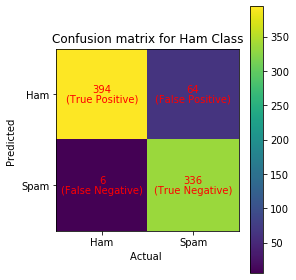

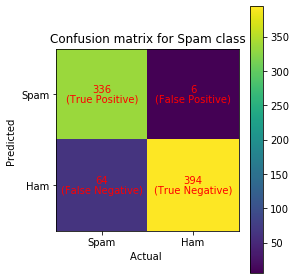

In [25]:
confusion_matrix(values= np.array([[ true_positive, false_positive ],
                                    [  false_negative,  true_negative]]), class_name = ['Ham', 'Spam'],title="Confusion matrix for Ham Class")


confusion_matrix(values= np.array([[ spam_true_positive , spam_false_positive ],
                                    [  spam_false_negative,  spam_true_negative]]), class_name = ['Spam', 'Ham'],title="Confusion matrix for Spam class")

### Evaluation Metrics

In [26]:
accuracy_ham = true_positive/(true_positive+false_negative)*100
accuracy_spam = spam_true_positive/(spam_true_positive+spam_false_negative)*100

accuracy_model=(true_positive+true_negative)/(true_positive+true_negative+false_positive+false_negative)*100

precision_ham = true_positive/(true_positive+false_positive)
precision_spam =  spam_true_positive/(spam_true_positive+spam_false_positive)

recall_ham =   true_positive/ (true_positive + false_negative)
recall_spam =  spam_true_positive/(spam_true_positive+spam_false_negative)

F1measure_ham =  2*(recall_ham * precision_ham) / (recall_ham + precision_ham)
F1measure_spam = 2*(recall_spam * precision_spam) / (recall_spam + precision_spam)

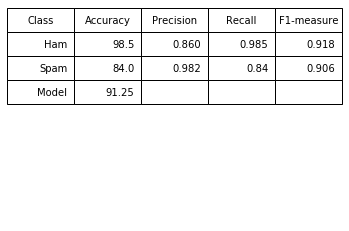

In [27]:
data = [["Ham", accuracy_ham, str("{:.3f}".format(float(precision_ham))), recall_ham, str("{:.3f}".format(float(F1measure_ham))) ],
        ["Spam", accuracy_spam, str("{:.3f}".format(float(precision_spam))) , recall_spam, str("{:.3f}".format(float(F1measure_spam))) ],
        ["Model", accuracy_model, "", "", ""]]

fig, axs =plt.subplots(2,1)
collabel=("Class","Accuracy", "Precision", "Recall","F1-measure")
axs[0].axis('tight')
axs[0].axis('off')
axs[1].axis("off")
the_table = axs[0].table(cellText=data,colLabels=collabel,loc='center')
the_table.auto_set_font_size(False)
the_table.set_fontsize(10)
the_table.scale(1, 2)
plt.show()